In [73]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import cvxpy as cp
from tqdm import tqdm
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
    })

In [10]:
# Load data from MNIST dataset (please uncompress data.zip)
# in csv format (Kaggle) 
# https://www.kaggle.com/oddrationale/mnist-in-csv/home
# First column = Label
# Other columns = Image
df_train = pd.read_csv('data/mnist_train.csv', header=None, index_col=None)
df_test  = pd.read_csv('data/mnist_test.csv',  header=None, index_col=None)

# Reduce size (to reduce size computations)
df_train = df_train.iloc[:3000]
df_test  = df_test.iloc[:1000]

# Split data in X and y
X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_test,  y_test  = df_test.iloc[:,  1:], df_test.iloc[:, 0]

# Basic visualizations

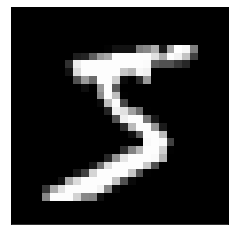

In [13]:
# Example image
x_test = X_train.iloc[0].to_numpy().reshape(-1, 28)
plt.imshow(x_test, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("single_digit.pdf")

In [18]:
# Example one image as long vector
x_test_tile = np.tile(x_test.reshape(-1, 1), (1, 10))
plt.imshow(x_test_tile, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig("single_digit_flattened.pdf")

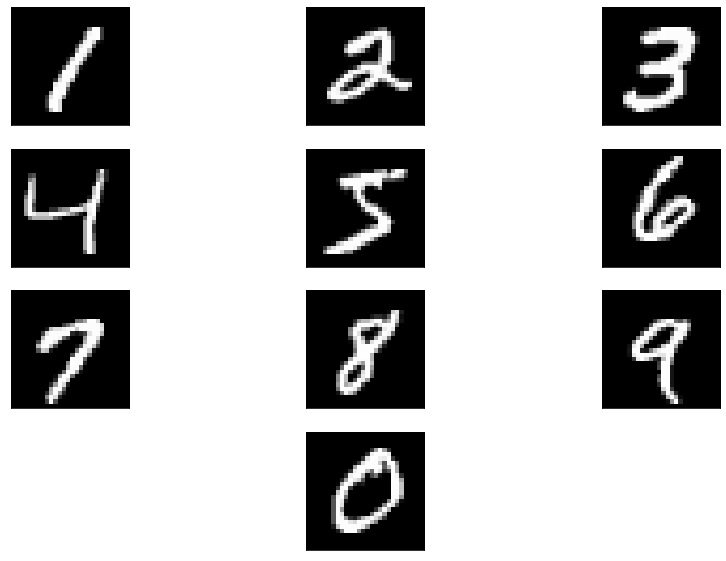

In [56]:
# Grid of numbers
fig, ax = plt.subplots(4, 3, figsize=(15, 10))

axs = ax.ravel()
for i in range(1, 10):
    idx_sample = np.where(y_train == i)[0][0]
    axs[i-1].imshow(X_train.iloc[idx_sample].to_numpy().reshape(-1, 28), cmap='gray')
    axs[i-1].set_xticks([])
    axs[i-1].set_yticks([])
    
idx_sample = np.where(y_train == 0)[0][0]
axs[10].imshow(X_train.iloc[idx_sample].to_numpy().reshape(-1, 28), cmap='gray')
axs[10].set_xticks([])
axs[10].set_yticks([])

fig.delaxes(axs[9])
fig.delaxes(axs[11])
plt.savefig("all_digits.pdf")


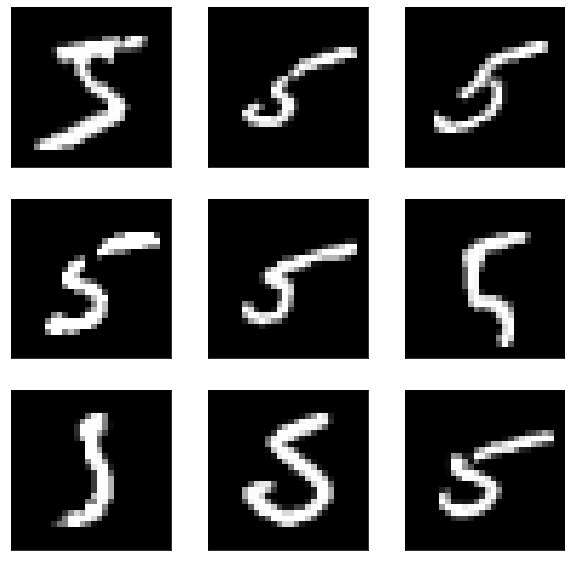

In [58]:
# Grid of same 5 numbers
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
axs = ax.ravel()

val = 5
idx_sample = np.where(y_train == val)[0]

for i in range(9):
    axs[i].imshow(X_train.iloc[idx_sample[i]].to_numpy().reshape(-1, 28), cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.savefig("5_digits.pdf")

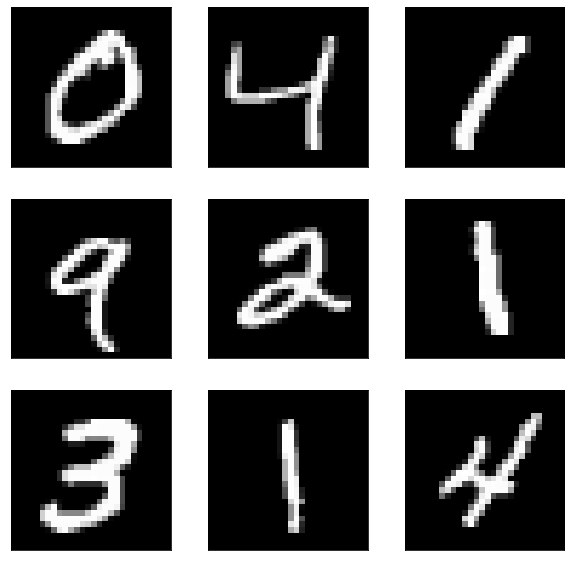

In [59]:
# Grid of same not 5 numbers
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
axs = ax.ravel()

val = 5
idx_sample = np.where(y_train != val)[0]

for i in range(9):
    axs[i].imshow(X_train.iloc[idx_sample[i]].to_numpy().reshape(-1, 28), cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.savefig("not_5_digits.pdf")

# Train and test validation

In [108]:
def make_classifier_validation(target_digit, X_train, y_train, X_test, y_test):
    
    n_trials = 40 
    lambda_vals = np.logspace(-2, 1, n_trials)
    train_error = np.zeros(n_trials)
    test_error = np.zeros(n_trials)
    a_values = []
    b_values = []
    
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    n = np.size(X_train, 1)

    # Create -1,+1 labels
    s_train = (y_train == target_digit).astype(int).to_numpy()
    s_train[s_train == 0] = -1 
    s_test = (y_test == target_digit).astype(int).to_numpy()
    s_test[s_test == 0] = -1 
    
    # Define SVM problem
    lam = cp.Parameter(nonneg=True)
    a = cp.Variable(n)
    b = cp.Variable()
    loss = cp.sum(cp.pos(1 - cp.multiply(s_train, X_train @ a + b)))/len(s_train)
    regularization  = cp.norm(a,1)
    problem = cp.Problem(cp.Minimize(loss + lam * regularization))
    
    for i in tqdm(range(n_trials)):
        lam.value = lambda_vals[i]
        problem.solve(solver=cp.ECOS)
        a_values += [a.value]
        b_values += [b.value]
        
        s_train_pred  = np.sign(X_train @ a.value + b.value)
        s_test_pred   = np.sign(X_test @ a.value + b.value)
        train_error[i] = (s_train != s_train_pred).sum()/len(y_train)
        test_error[i]  = (s_test != s_test_pred).sum()/len(y_test)       
        
    idx_best = np.argmin(test_error)    
    return a_values[idx_best], b_values[idx_best], lambda_vals, train_error, test_error

In [105]:
a, b, lambda_vals, train_error, test_error = make_classifier_validation(5, X_train, y_train, X_test, y_test)

100%|███████████████████████████████████████████████████████████| 40/40 [01:44<00:00,  2.62s/it]


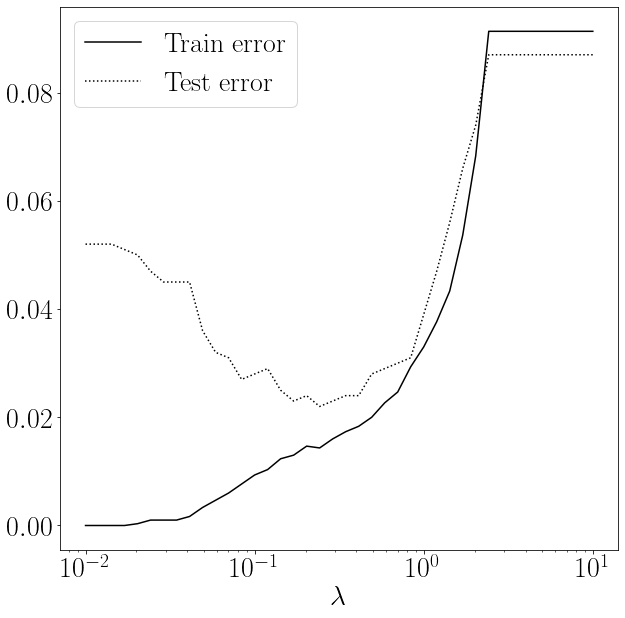

In [107]:
n_trials = 40
lambda_vals = np.logspace(-2, 1, n_trials)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(lambda_vals, train_error, label=r"${\rm Train\; error}$", color="k")
ax.plot(lambda_vals, test_error, label=r"$\rm{Test\; error}$", color="k", linestyle="dotted")
ax.set_xscale('log')
ax.legend()
ax.set_xlabel(r"$\lambda$")
plt.savefig("train_test_digit_5.pdf")

# Multiclass classification

In [115]:
# Train all classifiers with lam = 0.25 
# Note: validating lam for all of them would take a long time...
def make_classifier(target_digit, X, y):
    X = X.to_numpy()
    n = np.size(X, 1)

    # Create -1,+1 labels
    s = (y == target_digit).astype(int).to_numpy()
    s[s == 0] = -1 
    
    # Define SVM problem
    lam = 0.25
    a = cp.Variable(n)
    b = cp.Variable()
    loss = cp.sum(cp.pos(1 - cp.multiply(s, X @ a + b)))/len(s)
    regularization  = cp.norm(a,1)
    problem = cp.Problem(cp.Minimize(loss + lam * regularization))
    problem.solve(solver=cp.ECOS)
    return a.value, b.value

In [113]:
svm_a = []
svm_b = []

for i in tqdm(range(10)):
 a, b = make_classifier(i, X_train, y_train)
 svm_a.append(a)
 svm_b.append(b)

100%|███████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.76s/it]


In [116]:
def predict(X, a, b):
    return np.argmax([X.dot(a[i]) + b[i] for i in range(10)])

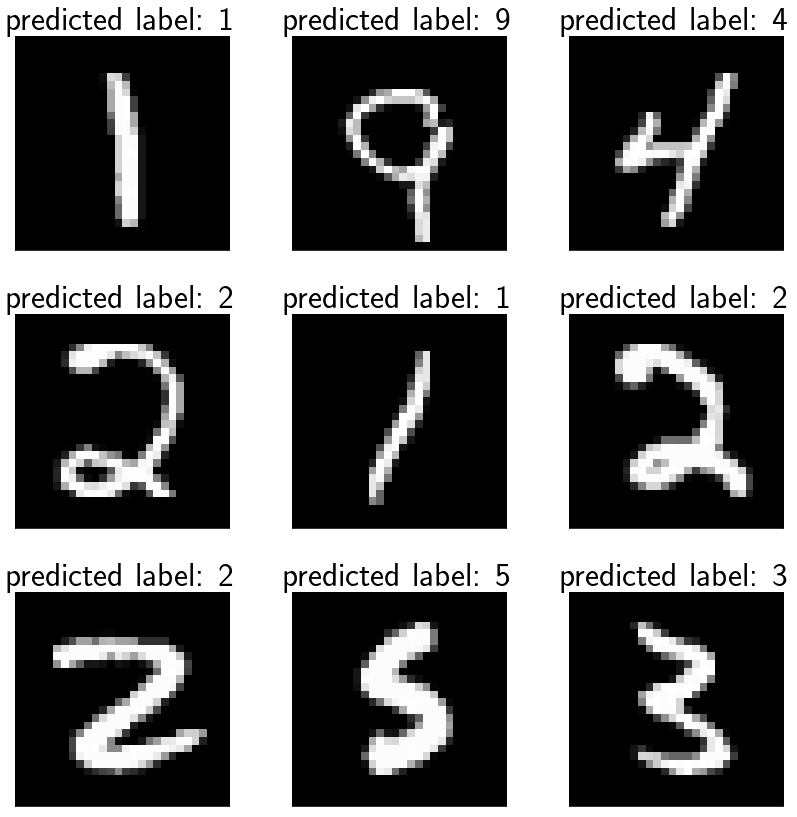

In [122]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
axs = ax.ravel()

np.random.seed(1)
rand_idx = np.random.randint(0, len(y_test), 9)

for i in range(9):
    x_test = X_test.to_numpy()[rand_idx[i]];
    
    #predicted value
    y_pred = predict(x_test, svm_a, svm_b)
    
    #plot it and show the prediction
    x_i = np.reshape(x_test, (-1, 28))
    axs[i].set_title('predicted label: %i' % y_pred)
    axs[i].imshow(x_i, cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
plt.tight_layout()
plt.savefig("multiclass_classification.pdf")